<a href="https://colab.research.google.com/github/artmen1516/emotions-classification-seedv/blob/main/process_seedv_raw_files_with_mne_from_drive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotions classification using SEED-V dataset
Created by [Arturo Mendivil](https://www.linkedin.com/in/arturomendivil/) <br>
Instituto Tecnologico de Tijuana (ITT) - MSc IT <br>
m22210007@tectijuana.edu.mx

# Prepare Libraries and Files
This section install dependencies, connects to GDrive and load files

In [ ]:
#@title Python version being used
%%python3 -V

Python 3.10.12


In [ ]:
#@title Install Dependencies
#@markdown Install mne, numpy, and matplotlib
# Import libraries
%pip install mne --quiet
# %pip install -U scikit-learn
# %pip install -U skorch
%pip install braindecode==0.8 --no-cache-dir
%pip install torchsummary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 35.0 MB/s eta 0:00:00
Reason for being yanked: <none given>
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 198.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 140.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 119.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 185.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 112.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 162.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 134.2 MB/s eta 0

In [ ]:
%pip uninstall braindecode -y
%pip install braindecode --no-cache-dir

Found existing installation: braindecode 0.8
Uninstalling braindecode-0.8:
  Successfully uninstalled braindecode-0.8
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.2/165.2 kB 8.5 MB/s eta 0:00:00


In [ ]:
#@title Load Dependencies
#@markdown Install mne, numpy, and matplotlib
# Import libraries

import numpy as np
import mne
import matplotlib
import json
import os
import torch
import pandas

# Print numpy and mne versions
print("numpy version: {}".format(np.__version__)) #1.22.4
print("mne version: {}".format(mne.__version__)) #1.4.0
print("matplotlib version: {}".format(matplotlib.__version__))
print("json version: {}".format(json.__version__))

import matplotlib.pyplot as plt
# import create_from_mne_raw, create_from_mne_epochs from braindecode.datasets

numpy version: 1.26.4
mne version: 1.8.0
matplotlib version: 3.7.1
json version: 2.0.9


In [ ]:
#@title Connect to Google drive
#@markdown connection to gdrive to download files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Select folder to process
#@markdown Path to where files are located
base_dir = '/content/drive/Shareddrives/ITT-MTI/Tesis/Databases/SEED-V/SEED-V/EEG_raw/' #@param {type:"string"}
raw_files_dir = '/content/drive/Shareddrives/ITT-MTI/Tesis/Databases/SEED-V/SEED-V/EEG_raw/files/' #@param {type:"string"}
processed_files_dir = '/content/drive/Shareddrives/ITT-MTI/Tesis/Databases/SEED-V/SEED-V/EEG_raw/processed/' #@param {type:"string"}
labeled_files_dir = '/content/drive/Shareddrives/ITT-MTI/Tesis/Databases/SEED-V/SEED-V/EEG_raw/labeled/' #@param {type:"string"}

processed_file = '/content/drive/Shareddrives/ITT-MTI/Tesis/Databases/SEED-V/SEED-V/EEG_raw/processed/1_1_20180804_raw.fif' #@param {type:"string"}


# Data Processing (ONLY IF THERE ARE NOT PROCESSED FILES)
This section loads all raw signal, process them, label them, and store them in gdrive in a new format with important information about each emotion

## RAW Files Preprocessing
This section is to preprocess all the RAW signals from SEED-V dataset by applying downsampling, bandpass filtering, labeling, saving new files, plot information, etc.

In [ ]:
#@title Load files and display info
#@markdown Use mne to load the files

processed_eeg_file = mne.io.read_raw_fif(processed_file)
print(processed_eeg_file)

files_dict_vars = {}
for i, filename in enumerate(os.listdir(raw_files_dir)):
    f = os.path.join(raw_files_dir, filename)
    # checking if it is a file
    print('processing file ', filename,'...')
    if os.path.isfile(f):
      varname = os.path.splitext(filename)[0]
      raw_varname = 'raw_'+varname
      files_dict_vars[raw_varname] = mne.io.read_raw_cnt(f)
print(files_dict_vars)

KeyboardInterrupt: 

In [ ]:
#@title Drop non-used channels
#@markdown Drop 'M1', 'M2', 'VEO', 'HEO'

for eeg_raw_name, eeg_raw in files_dict_vars.items():
  print('processing file ', eeg_raw_name,'...')
  # check channel names
  ch_names = eeg_raw.ch_names
  print('All channels')
  print(len(ch_names))

  # drop non-used channels
  # useless_ch = ['M1', 'M2', 'VEO', 'HEO']
  useless_ch = ['M1', 'M2', 'VEO', 'HEO']
  eeg_raw.drop_channels(useless_ch)
  new_ch = eeg_raw.ch_names
  print('Channels after drop')
  print(len(new_ch))


In [ ]:
len(files_dict_vars['raw_13_2_20180806'].ch_names)

In [ ]:
#@title Downsampling and Filtering All files
#@markdown #### ONLY USE WHEN SAVING PROCESSED FILES, AFTER SAVING IS NO LONGER REQUIRED

CODE_ENABLED = False #@param {type:"boolean"}

#@markdown - Apply downsampling from 1000Hz -> 200Hz
#@markdown - Apply bandpass filter from 1Hz to 75Hz
#@markdown - Save processed files
# Downsample and filter

if CODE_ENABLED:
  processed_dict_vars = {}

  for eeg_raw_name, eeg_raw in files_dict_vars.items():
    print('processing file '+eeg_raw_name,'...')
    eeg_raw_downsampled = eeg_raw.copy().resample(sfreq=200)
    # eeg_raw_filtered = eeg_raw.load_data().filter(1,75)
    folder = 'processed'
    filename = eeg_raw_name+'_raw.fif'
    varname = 'processed_'+eeg_raw_name
    print('filtered file: ',varname)
    processed_dict_vars[varname] = eeg_raw_downsampled.load_data().filter(1,75)

    # ONLY USED TO SAVE NEW FILES
    # processed_dict_vars[varname].save(os.path.join(base_dir,folder, filename), overwrite=False)

if not CODE_ENABLED:
  print('This cell is disabled')


In [ ]:
#@title Downsampling and Filtering One file
#@markdown #### USED TO PROCESS ONE FILE, IF A FILE PROCESSED IS ALREADY IMPORTED THIS IS NOT NEEDED

CODE_ENABLED = False #@param {type:"boolean"}

#@markdown - Apply downsampling from 1000Hz -> 200Hz
#@markdown - Apply bandpass filter from 1Hz to 75Hz

if CODE_ENABLED:
  raw_file = files_dict_vars['raw_1_1_20180804']
  raw_file_downsampled = raw_file.copy().resample(sfreq=200)
  raw_file_downsampled.load_data().filter(1,75)

if not CODE_ENABLED:
  print('This cell is disabled')

In [ ]:
#@title Plot Downsampled signal PSD
#@markdown Display PSD of original signal and PSD after Downsampling
for data, title in zip([files_dict_vars['raw_1_1_20180804'], processed_eeg_file], ["Original", "Downsampled"]):
    fig = data.compute_psd().plot(average=True, picks="data", exclude="bads")
    # fig.subplots_adjust(right=0.9)
    # plt.setp(fig.axes, xlim=(0, 300))

In [ ]:
#@title Plot RAW signals vs Processed signals
#@markdown Plot corresponding to subject #1, clip #1 for the first 5 seconds
#@markdown <br>Only plotting 5 channels "C1", "C2", "C3", "C4", "CZ" for better visualization
#@markdown <br>(a) RAW Signals
#@markdown <br>(b) Processed Signals
# ------ PLOT SIGNALS -------
channel_names = ["C1", "C2", "C3", "C4", "CZ"]
for i, (data, title) in enumerate(zip([files_dict_vars['raw_1_1_20180804'], processed_eeg_file], ["(a)", "(b)"])):
  sampling_freq = data.info["sfreq"]
  print(sampling_freq)
  start_stop_seconds = np.array([30, 35])
  start_sample, stop_sample = (start_stop_seconds * sampling_freq).astype(int)
  raw_selection = data[channel_names, start_sample:stop_sample]
  x = raw_selection[1]
  y = raw_selection[0].T
  plt.figure(i, figsize=(9, 3))
  plt.plot(x, y)
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude (µV)')
  plt.legend(channel_names)
  plt.title(title)
plt.show()


In [ ]:
files_dict_vars['raw_1_1_20180804'].plot_sensors(kind='topomap', ch_type='eeg', show_names=True, sphere=0.5 )


In [ ]:
files_dict_vars['raw_1_1_20180804'].compute_psd(fmax=100).plot()
processed_eeg_file.compute_psd(fmax=100).plot()

## Segmentation Using Processed Files
This section uses the files saved in previous section.<br>
This section is for segmentation, by annotating time sections we can then create epochs from the annotations to process in a machine learning model.

In [ ]:
#@title Define start, end, emotion, emotion id for each session
#@markdown Create the start_second, end_second, emotions, emotions_id variables for each session
#information from Dataset files

# session1_start_second= [30, 132, 287, 555, 773, 982, 1271, 1628, 1730, 2025, 2227, 2435, 2667, 2932, 3204]
# session1_end_second= [102, 228, 524, 742, 920, 1240, 1568, 1697, 1994, 2166, 2401, 2607, 2901, 3172, 3359]
session1_start_second= [41,155,380,623,821,1086,1394,1637,1837,2070,2289,2496,2759,3027,3256]
session1_end_second= [91,205,430,673,871,1136,1444,1687,1887,2120,2339,2546,2809,3077,3306]
session1_emotions= ['Happy','Fear','Neutral','Sad','Disgust','Happy','Fear','Neutral','Sad','Disgust','Happy','Fear','Neutral','Sad','Disgust']
session1_emotions_id= [4,1,3,2,0,4,1,3,2,0,4,1,3,2,0]

# session2_start_second= [30, 299, 548, 646, 836, 1000, 1091, 1392, 1657, 1809, 1966, 2186, 2333, 2490, 2741]
# session2_end_second= [267, 488, 614, 773, 967, 1059, 1331, 1622, 1777, 1908, 2153, 2302, 2428, 2709, 2817]
session2_start_second= [123,368,556,684,876,1004,1186,1482,1692,1833,2034,2219,2355,2574,2754]
session2_end_second= [173,418,606,734,926,1054,1236,1532,1742,1883,2084,2269,2405,2624,2804]
session2_emotions= ['Sad','Fear','Neutral','Disgust','Happy','Happy','Disgust','Neutral','Sad','Fear','Neutral','Happy','Fear','Sad','Disgust']
session2_emotions_id= [2,1,3,0,4,4,0,3,2,1,3,4,1,2,0]

# session3_start_second= [30, 353, 478, 674, 825, 908, 1200, 1346, 1451, 1711, 2055, 2307, 2457, 2726, 2888]
# session3_end_second= [321, 418, 643, 764, 877, 1147, 1284, 1418, 1679, 1996, 2275, 2425, 2664, 2857, 3066]
session3_start_second= [150,360,535,694,826,1002,1217,1357,1540,1828,2140,2341,2535,2766,2952]
session3_end_second= [200,410,585,744,876,1052,1267,1407,1590,1878,2190,2391,2585,2816,3002]
session3_emotions= ['Sad','Fear','Neutral','Disgust','Happy','Happy','Disgust','Neutral','Sad','Fear','Neutral','Happy','Fear','Sad','Disgust']
session3_emotions_id= [2,1,3,0,4,4,0,3,2,1,3,4,1,2,0]


In [ ]:
#@title Variables Creation
#@markdown Creates necessary data to create variables sessionX_event_id, sessionX_duration used in following sections
# ---- Create Dictionaries for each session ----
# Note: Only needed to create the variables

# ----- THIS MAY NOT BE NEEDED SINCE WHEN CONVERTING ANNOTATIONS TO EVENTS THIS IS DONE AUTOMATICALLY

# event_id_variables = ['session1_event_id', 'session2_event_id', 'session3_event_id']

# sessions_emotions = [session1_emotions,session2_emotions,session3_emotions]
# sessions_emotions_ids = [session1_emotions_id,session2_emotions_id,session3_emotions_id]
# for i, session in enumerate(sessions_emotions):
#   result = ''
#   for j, emotion in enumerate(session):
#     result+="'{}': {} ,".format(emotion, sessions_emotions_ids[i][j])
#   formatted_result = '"{'+result+'}"'
#   print(formatted_result)
#   globals()[event_id_variables[i]] = formatted_result

# -------------------------------------------

# ---- Create Durations for each session ----
# Note: Only needed to create the variables

duration_variables = ['session1_duration', 'session2_duration', 'session3_duration']

sessions_start = [session1_start_second, session2_start_second, session3_start_second]
sessions_end = [session1_end_second, session2_end_second, session3_end_second]

for i, session_starts in enumerate(sessions_start):
  duration_list = []
  for j, start in enumerate(session_starts):
    duration = sessions_end[i][j] - start
    duration_list.append(duration)
  print(duration_list)
  globals()[duration_variables[i]] = duration_list



In [ ]:
#@title Create MNE Annotations Variables
#@markdown Creates mne variables with annotations

session1_annotations = mne.Annotations(
    onset= session1_start_second,  # in seconds
    duration= session1_duration,  # in seconds, too
    description= session1_emotions,
)

session2_annotations = mne.Annotations(
    onset= session2_start_second,  # in seconds
    duration= session2_duration,  # in seconds, too
    description= session2_emotions,
)

session3_annotations = mne.Annotations(
    onset= session3_start_second,  # in seconds
    duration= session3_duration,  # in seconds, too
    description= session3_emotions,
)

session1_emotions=['Happy','Fear','Neutral','Sad','Disgust','Happy','Fear','Neutral','Sad','Disgust','Happy','Fear','Neutral','Sad','Disgust']
session2_emotions=['Sad','Fear','Neutral','Disgust','Happy','Happy','Disgust','Neutral','Sad','Fear','Neutral','Happy','Fear','Sad','Disgust']
session3_emotions=['Sad','Fear','Neutral','Disgust','Happy','Happy','Disgust','Neutral','Sad','Fear','Neutral','Happy','Fear','Sad','Disgust']
session_runs=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15']

subject1_session1=[2,4,5,2,1,4,5,4,3,2,4,4,5,5,2]
subject1_session2=[3,2,5,3,4,3,5,4,4,3,5,2,5,5,2]
subject1_session3=[3,2,5,5,2,5,3,4,2,5,5,3,5,4,5]
subject2_session1=[3,3,4,4,4,3,5,5,4,5,4,4,4,5,5]
subject2_session2=[4,2,5,4,4,4,3,5,5,4,4,5,5,4,1]
subject2_session3=[4,4,5,5,3,5,2,5,4,5,5,5,5,5,1]
subject3_session1=[4,3,4,3,4,5,5,5,5,4,5,4,5,5,4]
subject3_session2=[4,3,5,3,4,4,5,4,5,4,5,5,5,5,4]
subject3_session3=[5,4,5,5,4,4,4,5,5,5,4,5,5,5,5]
subject4_session1=[0,5,5,4,3,3,5,5,5,3,3,5,5,4,4]
subject4_session2=[3,4,5,1,4,3,5,5,5,5,3,4,5,2,1]
subject4_session3=[1,4,5,5,4,4,2,5,5,5,5,4,5,5,5]
subject5_session1=[5,4,5,4,5,4,5,5,3,4,3,2,5,5,5]
subject5_session2=[5,2,5,5,1,2,5,5,2,5,5,5,5,5,5]
subject5_session3=[2,3,5,5,2,4,2,5,3,5,5,4,4,5,5]
subject6_session1=[2,4,5,4,5,2,5,5,5,5,4,2,3,3,3]
subject6_session2=[4,3,5,2,3,3,4,5,4,4,5,5,4,5,3]
subject6_session3=[4,3,5,3,2,5,4,5,4,5,5,4,4,4,5]
subject7_session1=[3,2,5,3,2,3,5,5,4,3,4,4,4,5,5]
subject7_session2=[3,4,4,2,3,3,3,4,4,4,3,4,5,3,4]
subject7_session3=[3,3,4,5,2,4,2,4,3,5,4,4,4,4,5]
subject8_session1=[3,4,5,5,5,5,5,5,5,5,4,4,5,5,5]
subject8_session2=[3,5,5,3,4,4,5,5,5,5,5,5,5,4,1]
subject8_session3=[4,5,5,5,3,5,4,5,5,5,5,5,5,5,5]
subject9_session1=[2,5,4,5,4,4,5,4,5,5,5,5,5,5,5]
subject9_session2=[5,5,4,3,4,4,4,5,5,4,5,4,5,5,4]
subject9_session3=[5,4,3,5,4,5,4,5,5,5,5,5,5,5,5]
subject10_session1=[4,5,4,3,4,5,5,5,2,4,3,4,3,5,5]
subject10_session2=[2,3,4,3,4,4,5,3,2,4,3,5,4,3,4]
subject10_session3=[5,4,4,5,2,5,4,3,1,5,4,4,5,4,5]
subject11_session1=[4,3,5,4,4,5,5,5,4,3,4,4,5,5,5]
subject11_session2=[3,4,4,5,4,4,5,5,3,3,5,5,4,4,5]
subject11_session3=[3,4,4,5,5,5,4,5,4,5,4,5,4,5,5]
subject12_session1=[4,3,5,4,5,4,3,5,3,4,5,4,5,5,5]
subject12_session2=[2,4,5,3,4,4,5,5,3,4,5,4,4,5,4]
subject12_session3=[3,4,5,5,5,5,4,5,5,5,5,4,5,3,5]
subject13_session1=[0,5,5,3,4,1,5,5,5,5,3,2,5,3,3]
subject13_session2=[3,0,5,0,3,2,4,5,5,3,4,3,5,4,3]
subject13_session3=[3,5,5,5,0,2,3,5,2,5,5,3,4,3,5]
subject14_session1=[3,4,5,5,5,4,5,5,2,5,3,5,3,4,4]
subject14_session2=[3,5,5,4,5,4,5,5,5,5,4,5,5,4,4]
subject14_session3=[2,5,5,5,4,4,4,5,3,5,5,5,2,5,5]
subject15_session1=[4,4,5,3,5,5,5,5,4,1,3,5,2,4,4]
subject15_session2=[3,2,5,2,4,4,4,5,4,3,4,5,4,4,1]
subject15_session3=[2,4,5,4,2,3,3,5,4,5,5,5,5,3,3]
subject16_session1=[2,5,4,4,5,3,5,5,4,3,4,4,4,3,3]
subject16_session2=[2,3,5,2,2,3,4,5,5,4,4,4,5,1,2]
subject16_session3=[1,4,5,5,2,5,3,5,3,5,4,5,3,4,5]


In [ ]:
#@title Load Processed Files
#@markdown Loads files into variables with "processed_" prefix

processed_dict_vars = {}
for i, filename in enumerate(os.listdir(processed_files_dir)):
  f = os.path.join(processed_files_dir, filename)
  # checking if it is a file
  print('processing file ', filename,'...')
  if os.path.isfile(f):
    varname = os.path.splitext(filename)[0]
    print(varname)
    processed_varname = 'processed_'+varname
    processed_dict_vars[processed_varname] = mne.io.read_raw_fif(f)
    print(processed_dict_vars[processed_varname].get_data().shape)
# print(processed_dict_vars)

In [ ]:
# annotated_signal = processed_dict_vars['processed_16_2_20180815_raw'].set_annotations(session2_annotations)
# print(annotated_signal.plot())

In [ ]:
#@title Create Epoch files from processed files
#@markdown Here we create epoch files with labeled data, for this purpose the following is beign done:
#@markdown 1. Create variable with annotations.
#@markdown 2. Create variable with events from annotations.
#@markdown 3. Create variable with epochs from events.
#@markdown 4. Save epoch file with labels.
import pandas as pd

events_ids = {'Disgust': 0, 'Fear': 1, 'Sad': 2, 'Neutral': 3, 'Happy': 4}
folder = 'labeled'

for eeg_processed_name, eeg_processed in processed_dict_vars.items():
  print('processing file ', eeg_processed_name,'...')
  print(processed_dict_vars[eeg_processed_name].get_data().shape)
  subject = eeg_processed_name.split('_')[1]
  session = eeg_processed_name.split('_')[2]
  session_var_name = f"session{session}_annotations"
  emotion_var_name = f"session{session}_emotions"
  emotions_id_var_name = f"session{session}_emotions_id"
  score_var_name = f"subject{subject}_session{session}"
  annotations_for_session = globals()[session_var_name]
  print(annotations_for_session)
  print(globals()[score_var_name])
  new_filename = eeg_processed_name+'_epo.fif'
  #Annotate Signal
  eeg_processed_annotations = processed_dict_vars[eeg_processed_name].set_annotations(annotations_for_session)
  # Create event from annotations
  events, events_id = mne.events_from_annotations(eeg_processed_annotations, event_id=events_ids)
  # Create epochs from events
  epochs = mne.Epochs(processed_dict_vars[eeg_processed_name], events, event_id=events_ids, tmin=-0, tmax=50, baseline=None)
  n_epochs = len(epochs.events)
  # print([subject] * n_epochs)
  emotions = globals()[emotion_var_name]
  emotions_ids = globals()[emotions_id_var_name]
  scores = globals()[score_var_name]
  new_metadata = pd.DataFrame(
    {
        'subject': [subject] * n_epochs,
        'session': [session] * n_epochs,
        'emotion': emotions,
        'target': emotions_ids,
        'score': scores,
        'run': session_runs,
     }
  )
  epochs.metadata = new_metadata
  print(epochs.metadata)
  # epochs.save(os.path.join(base_dir,folder, new_filename), overwrite=True)


# Neural Network Load files
Load Already processed files, filter by score, and convert dataset to epochs

In [ ]:
%%capture
#@title Load labeled files

labeled_dict_vars = {}
for i, filename in enumerate(os.listdir(labeled_files_dir)):
  f = os.path.join(labeled_files_dir, filename)
  # checking if it is a file
  print('processing file ', filename,'...')
  if os.path.isfile(f):
    varname = os.path.splitext(filename)[0]
    print(varname)
    labeled_varname = 'labeled_'+varname
    labeled_dict_vars[labeled_varname] = mne.read_epochs(f)


In [ ]:
%%capture
#@title Filter Epochs by Score
#@markdown Only select epochs which have 4 or more score
list_of_epochs = [epochs[epochs.metadata['score'] >= 4] for epochs in labeled_dict_vars.values()]
list_of_all_epochs = [epoch for epoch in labeled_dict_vars.values()]
# list_of_epochs_np = mne.EpochsArray(list_of_epochs)
# all_epochs = mne.concatenate_epochs(list_of_epochs)

print('Len by all epochs', len(list_of_all_epochs))
print('Len filtered by score', len(list_of_epochs))
epochs_metadata = [epoch.metadata for epoch in list_of_epochs]
print(epochs_metadata)

In [ ]:
#@title Display Epoch information
print(list_of_epochs[0].info)
print(list_of_epochs[0].events.shape)
sfreq = list_of_epochs[0].info['sfreq']
ch_names = list_of_epochs[0].info['ch_names']
subject_info = list_of_epochs[0].info['subject_info']
print(subject_info)
print(ch_names)

<Info | 11 non-empty values
 bads: []
 ch_names: FP1, FPZ, FP2, AF3, AF4, F7, F5, F3, F1, FZ, F2, F4, F6, F8, ...
 chs: 62 EEG
 custom_ref_applied: False
 dig: 69 items (3 Cardinal, 66 EEG)
 file_id: 4 items (dict)
 highpass: 1.0 Hz
 lowpass: 75.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 62
 projs: []
 sfreq: 200.0 Hz
 subject_info: 2 items (dict)
>
(12, 3)
{'id': 0, 'sex': 0}
['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', 'CB1', 'O1', 'OZ', 'O2', 'CB2']


In [ ]:
for epochs in list_of_epochs:
    event_descriptions = epochs.events[:, 2]
    print(event_descriptions)

[3 2 0 1 3 2 0 4 1 3 2 0]
[3 0 4 0 3 2 1 3 4 1 2 0]
[3 2 0 1 3 2 0 4 1 3 2 0]
[3 0 4 0 3 2 1 3 4 1 2 0]
[3 0 4 0 3 2 1 3 4 1 2 0]
[3 0 4 0 3 2 1 3 4 1 2 0]
[3 2 0 1 3 2 0 4 1 3 2 0]
[3 2 0 1 3 2 0 4 1 3 2 0]
[3 0 4 0 3 2 1 3 4 1 2 0]
[3 0 4 0 3 2 1 3 4 1 2 0]
[3 2 0 1 3 2 0 4 1 3 2 0]
[3 0 4 0 3 2 1 3 4 1 2 0]
[3 0 4 0 3 2 1 3 4 1 2 0]
[3 0 4 0 3 2 1 3 4 1 2 0]
[3 0 4 0 3 2 1 3 4 1 2 0]
[3 2 0 1 3 2 0 4 1 3 2 0]
[3 0 4 0 3 2 1 3 4 1 2 0]
[3 0 4 0 3 2 1 3 4 1 2 0]
[3 2 0 1 3 2 0 4 1 3 2 0]
[3 2 0 1 3 2 0 4 1 3 2 0]
[3 0 4 0 3 2 1 3 4 1 2 0]
[3 0 4 0 3 2 1 3 4 1 2 0]
[3 0 4 0 3 2 1 3 4 1 2 0]
[3 0 4 0 3 2 1 3 4 1 2 0]
[3 2 0 1 3 2 0 4 1 3 2 0]
[3 2 0 1 3 2 0 4 1 3 2 0]
[3 2 0 1 3 2 0 4 1 3 2 0]
[3 2 0 1 3 2 0 4 1 3 2 0]
[3 0 4 0 3 2 1 3 4 1 2 0]
[3 2 0 1 3 2 0 4 1 3 2 0]
[3 2 0 1 3 2 0 4 1 3 2 0]
[3 0 4 0 3 2 1 3 4 1 2 0]
[3 0 4 0 3 2 1 3 4 1 2 0]
[3 0 4 0 3 2 1 3 4 1 2 0]
[3 0 4 0 3 2 1 3 4 1 2 0]
[3 0 4 0 3 2 1 3 4 1 2 0]
[3 0 4 0 3 2 1 3 4 1 2 0]
[3 2 0 1 3 2 0 4 1 3 2 0]
[3 2 0 1 3 2

In [ ]:
%%capture
#@title Create Window Dataset from Epochs
#@markdown Create dataset using the previously processed signals time-window

from braindecode.datasets import create_from_mne_epochs
# from braindecode.preprocessing import create_windows_from_events

trial_window_time = 50
trial_window_stride_time = 0.01
trial_window_time_samples = int(trial_window_time * sfreq)
trial_window_stride_samples = int(trial_window_stride_time * sfreq)

print(trial_window_time_samples)
print(trial_window_stride_samples)

windows_dataset = create_from_mne_epochs(
    list_of_epochs,
    trial_window_time_samples,
    trial_window_stride_samples,
    drop_last_window=True,
)

windows_dataset.description

cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = "cuda" if cuda else "cpu"
if cuda:
    torch.backends.cudnn.benchmark = True

n_classes = 5
classes = list(range(n_classes))
n_channels = windows_dataset[0][0].shape[0]
input_window_samples = windows_dataset[0][0].shape[1]

print('n_channels', n_channels)
print('n_classes', n_classes)
print('input_window_samples', input_window_samples)



# Neural Network - Model Configuration
Load model and parameters to use in training, also displays current model configuration.

In [ ]:
#@title Model Configuration
#@markdown Train model using specified parameters
training_percent = 0.8 # @param {type:"slider", min:0.5, max:0.8, step:0.1}
learning_rate = 0.01 # @param [0.0001, 0.0005, 0.000625, 0.001, 0.0042, 0.005, 0.0085, 0.01, 0.02, 0.042, 0.1, 0.42] {type:"raw"}
weight_decay = 0.05 # @param {type:"number"}
batch_size = 6 # @param [4, 6, 8, 12, 16,  32, 64, 128, 256] {type:"raw"}
n_epochs = 100 # @param {type:"number"}
model_option = "EEGNetv4" # @param ["ShallowFBCSPNet", "Deep4Net", "EEGNetv4"]
training_option = "train-val-test" # @param ["train-val-test",  "kfold-cross-val"]
lr = learning_rate

from IPython.display import display, clear_output
from skorch.dataset import ValidSplit
from skorch.helper import predefined_split, SliceDataset
from skorch.callbacks import LRScheduler
from torch.utils.data import Subset
from braindecode import EEGClassifier
from braindecode.models import ShallowFBCSPNet
from braindecode.models import EEGInception
from braindecode.models import Deep4Net
from braindecode.models import EEGNetv4
from braindecode.models.util import to_dense_prediction_model
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from torchsummary import summary
import math

if model_option == "ShallowFBCSPNet":
  mymodel = ShallowFBCSPNet(
      n_channels,
      n_classes,
      n_times=input_window_samples,
      final_conv_length='auto'
      )

if model_option == "Deep4Net":
  mymodel = Deep4Net(
    n_channels,
    n_classes,
    n_times=input_window_samples,
    final_conv_length='auto'
    )

if model_option == "EEGNetv4":
  mymodel = EEGNetv4(
    n_channels,
    n_classes,
    n_times=input_window_samples,
    final_conv_length='auto'
    )

if cuda:
    mymodel.cuda()

# Print Model Architecture
print('Current Model Architecture')
# print(mymodel)
summary(mymodel, (n_channels, input_window_samples))
# print(mymodel.summary())





Current Model Architecture
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          Ensure4d-1         [-1, 62, 10000, 1]               0
         Rearrange-2         [-1, 1, 62, 10000]               0
            Conv2d-3         [-1, 8, 62, 10001]             512
       BatchNorm2d-4         [-1, 8, 62, 10001]              16
Conv2dWithConstraint-5         [-1, 16, 1, 10001]             992
       BatchNorm2d-6         [-1, 16, 1, 10001]              32
        Expression-7         [-1, 16, 1, 10001]               0
         AvgPool2d-8          [-1, 16, 1, 2500]               0
           Dropout-9          [-1, 16, 1, 2500]               0
           Conv2d-10          [-1, 16, 1, 2501]             256
           Conv2d-11          [-1, 16, 1, 2501]             256
      BatchNorm2d-12          [-1, 16, 1, 2501]              32
       Expression-13          [-1, 16, 1, 2501]               0
        Av

# Neural Network - Training Section
Neural Network training and display results

In [ ]:
%%capture
#@title Model Training

# Train model on GPU
if cuda:
    mymodel.cuda()

# Get the list of targets
y = [epoch.metadata['target'].values for epoch in list_of_epochs]
y = np.concatenate(y)

# Calculate the samples for training and testing
total_array_samples = len(y)
train_samples = math.floor((training_percent*total_array_samples))
trainList =  list(range(1, train_samples + 1, 1))
testList =  list(range(train_samples + 1, total_array_samples, 1))
val_percent = 1 - training_percent

print('Total Array Samples:',total_array_samples)
print('Train Samples:',train_samples)

# Split Dataset into train and test subsets
splits = windows_dataset.split({"train": trainList, "test": testList})
train_set = splits['train']
test_set = splits['test']
y_train_set = y[0:train_samples]
y_test_set = y[train_samples + 1:]

train_set = windows_dataset
X_train = SliceDataset(train_set, idx=0)
y_train = np.array([y for y in SliceDataset(train_set, idx=1)])

train_indices, val_indices = train_test_split(
    X_train.indices_, test_size=val_percent, shuffle=False
)
train_subset = Subset(train_set, train_indices)
val_subset = Subset(train_set, val_indices)

print("train_subset")
print(len(train_subset))
print("test_subset")
print(len(val_subset))

events_ids = {'Disgust': 0, 'Fear': 1, 'Sad': 2, 'Neutral': 3, 'Happy': 4}

if training_option == "train-val-test":
  # --------- CLASSIFIER TRAIN-VAL-TEST SPLIT ------------------
  clf = EEGClassifier(
      mymodel,
      criterion=torch.nn.NLLLoss,
      optimizer=torch.optim.AdamW,
      train_split=predefined_split(val_subset),
      optimizer__lr=lr,
      optimizer__weight_decay=weight_decay,
      batch_size=batch_size,
      device=device,
      classes=events_ids,
      max_epochs=n_epochs,
      verbose=1,
      callbacks=[
      "accuracy",
      ("lr_scheduler", LRScheduler("CosineAnnealingLR", T_max=n_epochs - 1)),
      ]
  )

  clf.fit(train_subset, y=None)
  y_test = y_test_set
  test_acc = clf.score(test_set, y=y_test)
  print(f"Test acc: {(test_acc * 100):.2f}%")

if training_option == "kfold-cross-val":
  # --------- CLASSIFIER K-FOLD CROSS VALIDATION ------------------
  clf = EEGClassifier(
      mymodel,
      criterion=torch.nn.NLLLoss,
      optimizer=torch.optim.AdamW,
      train_split=None,
      optimizer__lr=lr,
      optimizer__weight_decay=weight_decay,
      batch_size=batch_size,
      device=device,
      classes=events_ids,
      max_epochs=n_epochs,
      verbose=1,
      callbacks=[
      "accuracy",
      ("lr_scheduler", LRScheduler("CosineAnnealingLR", T_max=n_epochs - 1)),
      ]
  )

  train_val_split = KFold(n_splits=5, shuffle=False)
  cv_results = cross_val_score(clf, X_train, y_train, scoring="accuracy", cv=train_val_split, n_jobs=1)
  print(
    f"Validation accuracy: {np.mean(cv_results * 100):.2f}"
    f"+-{np.std(cv_results * 100):.2f}%"
  )

In [ ]:
#@title Display training history
#@markdown display training history in a table for selected columns
import pandas as pd

training_history = pd.DataFrame(clf.history)
columnsOrder = ['epoch', 'train_accuracy', 'train_loss','valid_accuracy','valid_loss','event_lr','dur']
training_history.reindex(columns=columnsOrder)

,epoch,train_accuracy,train_loss,valid_accuracy,valid_loss,event_lr,dur
0,1,0.25,-523.591776,0.25,-2314.248809,0.010000,6.393363
1,2,0.25,-5456.767390,0.25,-21076.465383,0.009997,6.400058
2,3,0.25,-16067.818411,0.25,-34136.995420,0.009990,5.835975
3,4,0.25,-31056.632093,0.25,-73023.133217,0.009977,6.089019
4,5,0.25,-49579.618524,0.25,-73336.207435,0.009960,6.354399
...,...,...,...,...,...,...,...
95,96,0.25,-752842.497533,0.25,-650842.691810,0.000040,6.015565
96,97,0.25,-752304.397204,0.25,-650920.478448,0.000023,5.919131
97,98,0.25,-753062.851151,0.25,-651145.359914,0.000010,6.329551
98,99,0.25,-752878.518092,0.25,-651587.212284,0.000003,5.916637


In [ ]:
#@title Test trained model
import time

y_test = y_test_set
test_acc = clf.score(test_set, y=y_test)
print(f"Test acc: {(test_acc * 100):.2f}%")

# Generate current unix epoch timestamp

timestamp = int(time.time())

test_accuracy = round(test_acc * 100,2)
training_details = '''\ntest_acc: {0}%, training_percent: {1}, learning_rate: {2}, weight_decay: {3}, batch_size: {4}, n_epochs: {5}, model_option: {6},training_option: {7}, timestamp: {8}'''.format(
    test_accuracy,
    training_percent,
    learning_rate,
    weight_decay,
    batch_size,
    n_epochs,
    model_option,
    training_option,
    timestamp
    )

print(training_details)

my_path = "{0}/RESULTS/training_results.txt".format(base_dir)
myfile = open(my_path, "a+")
myfile.write(training_details)
myfile.close()

Using data from preloaded Raw for 1 events and 10000 original time points ...
Using data from preloaded Raw for 1 events and 10000 original time points ...
Using data from preloaded Raw for 1 events and 10000 original time points ...
Using data from preloaded Raw for 1 events and 10000 original time points ...
Using data from preloaded Raw for 1 events and 10000 original time points ...
Using data from preloaded Raw for 1 events and 10000 original time points ...
Using data from preloaded Raw for 1 events and 10000 original time points ...
Using data from preloaded Raw for 1 events and 10000 original time points ...
Using data from preloaded Raw for 1 events and 10000 original time points ...
Using data from preloaded Raw for 1 events and 10000 original time points ...
Using data from preloaded Raw for 1 events and 10000 original time points ...
Using data from preloaded Raw for 1 events and 10000 original time points ...
Using data from preloaded Raw for 1 events and 10000 original ti

Using data from preloaded Raw for 1 events and 10000 original time points ...
Using data from preloaded Raw for 1 events and 10000 original time points ...
Using data from preloaded Raw for 1 events and 10000 original time points ...
Using data from preloaded Raw for 1 events and 10000 original time points ...
Using data from preloaded Raw for 1 events and 10000 original time points ...
Using data from preloaded Raw for 1 events and 10000 original time points ...
Using data from preloaded Raw for 1 events and 10000 original time points ...
Using data from preloaded Raw for 1 events and 10000 original time points ...
Using data from preloaded Raw for 1 events and 10000 original time points ...
Using data from preloaded Raw for 1 events and 10000 original time points ...
Using data from preloaded Raw for 1 events and 10000 original time points ...
Using data from preloaded Raw for 1 events and 10000 original time points ...
Using data from preloaded Raw for 1 events and 10000 original ti

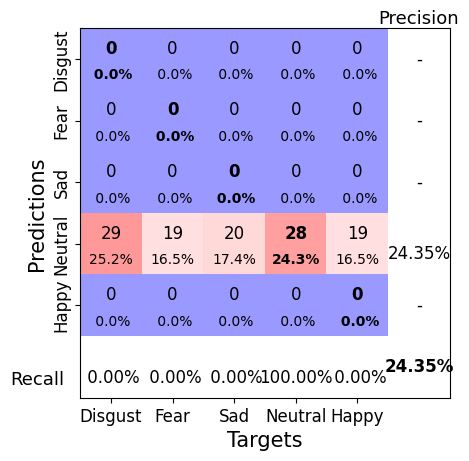

In [ ]:
#@title Display results in a Confusion Matrix
from sklearn.metrics import confusion_matrix
from braindecode.visualization import plot_confusion_matrix

# generate confusion matrices
# get the targets
y_true = y_test_set
y_pred = clf.predict(test_set)

# generating confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)

labels = {'Disgust': 0, 'Fear': 1, 'Sad': 2, 'Neutral': 3, 'Happy': 4}

# plot the basic conf. matrix
plot_confusion_matrix(confusion_mat, labels)

image_format = '_{0}_{1}_{2}_{3}_{4}_{5}_{6}.png'.format(
    test_accuracy,
    training_percent,
    learning_rate,
    weight_decay,
    batch_size,
    n_epochs,
    training_option,

    )

images_folder = 'RESULTS'
image_name = '{0}_{1}_confusion_matrix_{2}'.format(
    timestamp,
    model_option,
    image_format
)

plt.savefig(os.path.join(base_dir,images_folder,image_name))


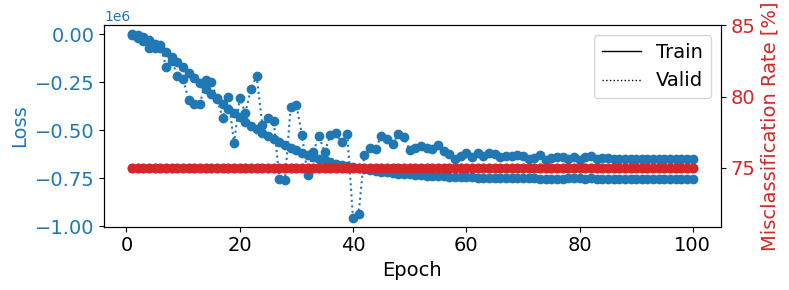

In [ ]:
#@title Display training parameters across epochs
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# Extract loss and accuracy values for plotting from history object
results_columns = ['train_loss', 'valid_loss', 'train_accuracy', 'valid_accuracy']
df = pd.DataFrame(clf.history[:, results_columns], columns=results_columns,
                  index=clf.history[:, 'epoch'])

# get percent of misclass for better visual comparison to loss
df = df.assign(train_misclass=100 - 100 * df.train_accuracy,
               valid_misclass=100 - 100 * df.valid_accuracy)

fig, ax1 = plt.subplots(figsize=(8, 3))
df.loc[:, ['train_loss', 'valid_loss']].plot(
    ax=ax1, style=['-', ':'], marker='o', color='tab:blue', legend=False, fontsize=14)

ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.set_ylabel("Loss", color='tab:blue', fontsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

df.loc[:, ['train_misclass', 'valid_misclass']].plot(
    ax=ax2, style=['-', ':'], marker='o', color='tab:red', legend=False)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)
ax2.set_ylabel("Misclassification Rate [%]", color='tab:red', fontsize=14)
ax2.set_ylim(ax2.get_ylim()[0], 85)  # make some room for legend
ax1.set_xlabel("Epoch", fontsize=14)

# where some data has already been plotted to ax
handles = []
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle='-', label='Train'))
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle=':', label='Valid'))
plt.legend(handles, [h.get_label() for h in handles], fontsize=14)
plt.tight_layout()

image_name = '{0}_{1}_loss_epochs_graph_{2}'.format(
    timestamp,
    model_option,
    image_format
)

plt.savefig(os.path.join(base_dir,images_folder,image_name))

In [ ]:
#@title Notify training finished
from google.colab import output

# output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')
# output.eval_js('new Audio("https://cdn.pixabay.com/audio/2022/03/15/audio_9dd36d9f22.mp3").play()')
output.eval_js('new Audio("https://cdn.pixabay.com/audio/2022/10/16/audio_10bebc0b9f.mp3").play()')